In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, DepthwiseConv2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [4]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [5]:
base_skin_dir = os.path.join('')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}



# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [6]:
skin_df = pd.read_csv(os.path.join('HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,input\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,input\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,input\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,input\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,input\ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [7]:
skin_df.isnull().sum()


lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [8]:
# Fill missing values in the Age column with the mean age of the dataset (51 years)

skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [9]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,input\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,input\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,input\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,input\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,input\ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [10]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [11]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


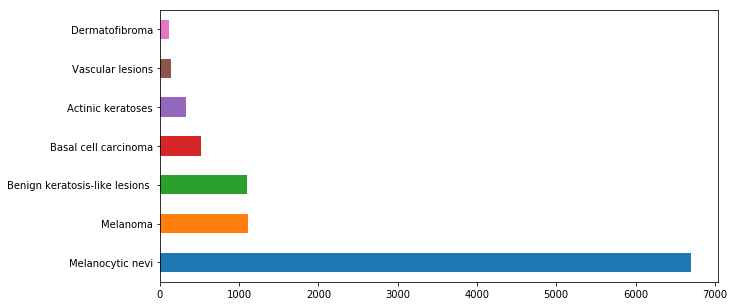

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='barh', ax=ax1)

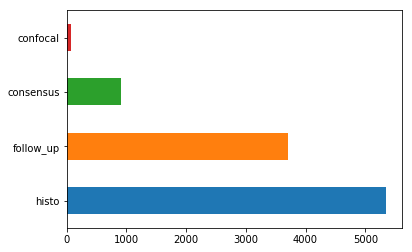

In [13]:
skin_df['dx_type'].value_counts().plot(kind='barh')

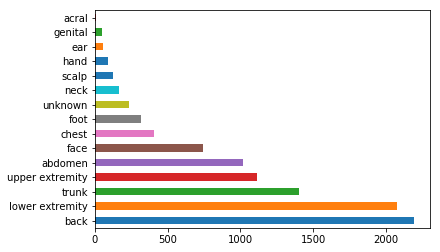

In [14]:
skin_df['localization'].value_counts().plot(kind='barh')

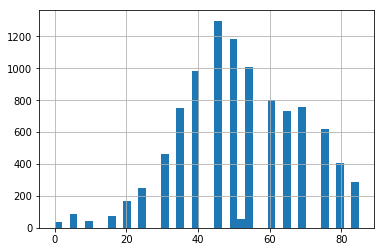

In [15]:
skin_df['age'].hist(bins=40)

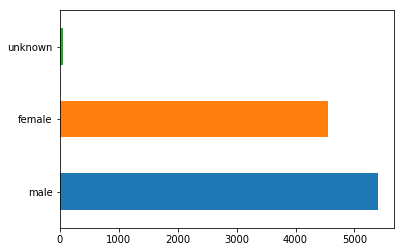

In [16]:
skin_df['sex'].value_counts().plot(kind='barh')

## Loading and resizing of images

In [17]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [18]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,input\ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,input\ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,input\ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,input\ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,input\ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


In [19]:
# n_samples = 2
# fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
# for n_axs, (type_name, type_rows) in zip(m_axs, 
#                                          skin_df.sort_values(['cell_type']).groupby('cell_type')):
#     n_axs[0].set_title(type_name)
#     for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
#         c_ax.imshow(c_row['image'])
#         c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

print ("Showing this message instead of gross skin ailments")

Showing this message instead of gross skin ailments


In [20]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [21]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

## Train, Test, Split

In [22]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=42)

In [23]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [24]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [25]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [26]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [29]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(DepthwiseConv2D(16, activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 128)      3584      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 128)      147584    
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 75, 100, 128)      32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        73792     
___________________________

## Setting Optimizer and Annealer

In [84]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# SGD(lr=0.001, momentum=1e-6, decay=0.7, nesterov=False)

In [85]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [86]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=True, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## Data Augmentation

In [87]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)


## Fitting the Model

In [89]:
# Fit the model
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
721/721 [==============================] - 815s 1s/step - loss: 0.9441 - acc: 0.6742 - val_loss: 0.9564 - val_acc: 0.6446
Epoch 2/50
721/721 [==============================] - 775s 1s/step - loss: 0.8823 - acc: 0.6814 - val_loss: 0.9164 - val_acc: 0.6521
Epoch 3/50
721/721 [==============================] - 774s 1s/step - loss: 0.8635 - acc: 0.6906 - val_loss: 0.9361 - val_acc: 0.6584
Epoch 4/50
721/721 [==============================] - 776s 1s/step - loss: 0.8463 - acc: 0.6949 - val_loss: 0.8889 - val_acc: 0.6608
Epoch 5/50
721/721 [==============================] - 771s 1s/step - loss: 0.8294 - acc: 0.7003 - val_loss: 0.8672 - val_acc: 0.6808
Epoch 6/50
721/721 [==============================] - 773s 1s/step - loss: 0.8142 - acc: 0.7031 - val_loss: 0.8426 - val_acc: 0.6721
Epoch 7/50
721/721 [==============================] - 779s 1s/step - loss: 0.8039 - acc: 0.7044 - val_loss: 0.8856 - val_acc: 0.6771
Epoch 8/50
721/721 [==============================] - 784s 1s/step - 

In [28]:
loss, accuracy = skin_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = skin_model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

# model.save("skin_model_charlie.h5")

802/802 [==============================] - 162s 202ms/step
Validation: accuracy = 0.805486  ;  loss_v = 0.509304
Test: accuracy = 0.825262  ;  loss = 0.476936


In [27]:
# from keras.models import load_model

# skin_model = load_model("skin_model_echo.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [33]:
model_loss, model_accuracy = skin_model.evaluate(
    x_test, y_test, verbose=1)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

2003/2003 [==============================] - 36s 18ms/step
Normal Neural Network - Loss: 0.5035915715481363, Accuracy: 0.8172740889857307


In [34]:
plot_model_history(history)

NameError: name 'history' is not defined

In [36]:
skin_model.predict


<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x00000194627B1518>>

In [119]:
from keras.preprocessing.image import img_to_array
from keras.applications.xception import (
    Xception, preprocess_input, decode_predictions)

def prepare_image(img):
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    # return the processed image
    return img

filepath = os.path.join("Input/ISIC_0024698.jpg")

image_size = (75, 100)

im = keras.preprocessing.image.load_img(filepath,
                                        target_size=image_size,
                                        grayscale=False)

# preprocess the image and prepare it for classification
image = prepare_image(im)

In [120]:
labels = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions', 'Basal cell carcinoma',
    'Actinic keratoses','Vascular lesions','Dermatofibroma']


preds = skin_model.predict(image)
# results = decode_predictions(preds)



result_df = pd.DataFrame(columns=['Label',"Prediction"])

for x,y in zip(preds[0],labels):
    
    result_df = result_df.append({'Label': y, 'Prediction': str(round(x*100, 4)) + "%"}, ignore_index=True)
    
result_df

,Label,Prediction
0,Melanocytic nevi,0.6127%
1,Melanoma,34.7422%
2,Benign keratosis-like lesions,9.8584%
3,Basal cell carcinoma,0.4475%
4,Actinic keratoses,53.8527%
5,Vascular lesions,0.0513%
6,Dermatofibroma,0.4352%
